In [9]:
%%shell
jupyter nbconvert --to html /content/Assignment1_421_Part1Numpy.ipynb

%%shell
jupyter nbconvert --to html /content/Assignment1_421_Part2Tensorflow.ipynb

[NbConvertApp] Converting notebook /content/Assignment1_421_Part1Numpy.ipynb to html
[NbConvertApp] Writing 976157 bytes to /content/Assignment1_421_Part1Numpy.html
/bin/bash: line 2: fg: no job control
[NbConvertApp] Converting notebook /content/Assignment1_421_Part2Tensorflow.ipynb to html
[NbConvertApp] Writing 609885 bytes to /content/Assignment1_421_Part2Tensorflow.html


# Programming Assignment 1

Name: Marcos David Madrigal Albores

Student Number: 1004731347

ECE421

This Assignment has been split into two ipynbs to avoid any possible conflicts that might have slipped my mind (note however, that the report appears as a single document due to pdf merging), the links to both ipynbs are displayed below:

Part 1 Logistic Regression with Numpy: https://colab.research.google.com/drive/1sc6YZqwaLvl-r7z52Vo7ovFq_9_VVc9d?usp=sharing

Part 2 Logistic Regression in Tensorflow:https://colab.research.google.com/drive/1liJfl32XRfqNA7wa-mzcQMaR9YM1fvri?usp=sharing 

# Part 1 Logistic Regression with Numpy

## 1.1 and 1.2 Loss Function and Gradient and Gradient Descent Implementation

Analytical forms for components of the model:


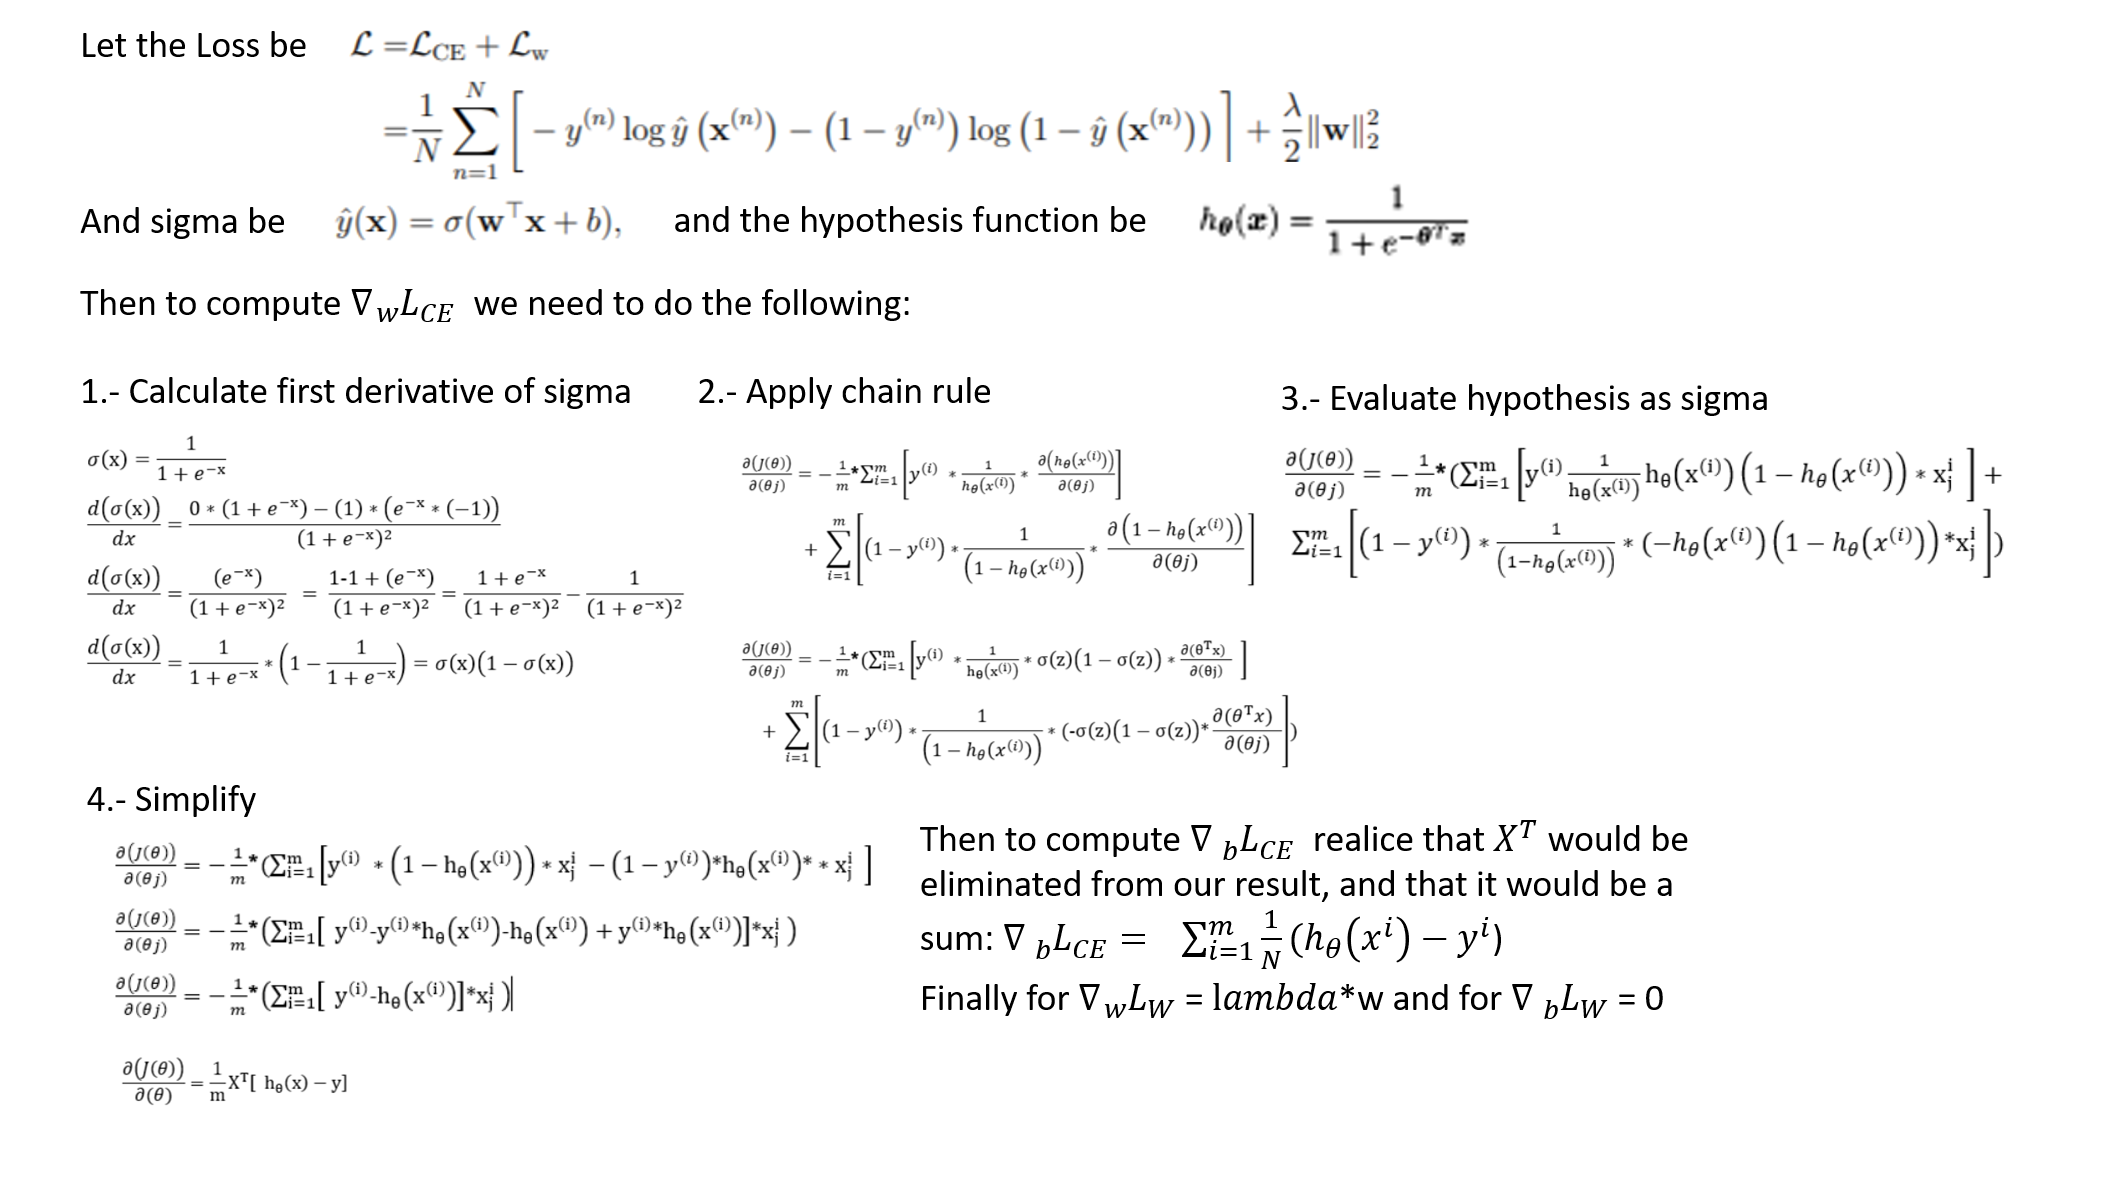

In [1]:
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/Marneus981/Ece421stuff.git

Cloning into 'Ece421stuff'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [2]:
#Data loading helper function
def loadData():
  with np.load('/content/Ece421stuff/notMNIST.npz') as data :
    Data, Target = data ['images'], data['labels']
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]
  return trainData, validData, testData, trainTarget, validTarget, testTarget

In [3]:
#We assume the arguments are the right type 
def get_actual_out_labels(y_hat):
  return np.where(y_hat > 0.5,1,0)

def get_acc_graph(y_hat,y):
  N = len(y)
  return 1-(1/N)*np.sum(np.absolute(y-y_hat)) 

def get_acc(y_hat,y):
  N = len(y)
  y_hat_actual = np.where(y_hat > 0.5,1,0)
  return np.sum(np.equal(y_hat_actual, y))/ N

def decision(w,b,x):
  w_transpose = np.transpose(w)
  z = w_transpose @ x.T + b                                            
  sigma = 1/(1+np.exp(-z))
  y_hat = sigma.T              
  return y_hat

def loss(w,b,x,y,lambda_reg):
  #Implementation
  #Idea:
  y_hat_plus = decision(w,b,x)
  y_hat_neg = decision(w,-b,-x)
  N = len(y)
  #Compute cross entropy loss L_ce
  L_ce = (1/N)*(-np.sum((y) * np.log(y_hat_plus)+(1-y) * np.log(1-y_hat_plus)))   
  #Compute regularization term L_w

  L_w = (lambda_reg/2)*np.square(np.linalg.norm(w))
  #Compute total loss
  L = float(L_ce + L_w)
  return L
  #Return loss
def grad_loss(w,b,x,y,lambda_reg):
  
  y_hat = decision(w,b,x)
  N = len(y)
  #Implementation
  #Idea:
  #Compute beforehand and return value of gradient of loss
  grad_L_w = (1/N)*(x.T @ (y_hat-y)) + (lambda_reg)*(w)                   
  grad_L_b = (1/N)*np.sum((y_hat-y)) 
  
  
  return (grad_L_w, grad_L_b)


def grad_descent(w,b,x,y,alpha,epochs,lambda_reg,error_tol, val_tuple, test_tuple): # Tuples of form  x,y
  #Implementation
  N = len(y)
  
  cost_hist_tr = np.zeros((epochs,1)) 
  acc_hist_tr = np.zeros((epochs,1))
  cost_hist_val = np.zeros((epochs,1))
  acc_hist_val = np.zeros((epochs,1))

  cost_test = 0.0
  acc_test = 0.0

  for i in range(epochs): #Training stops if the total number of epochs is reached
    w_old = w
    b_old = b
    grad_w,grad_b = grad_loss(w,b,x,y,lambda_reg)
    w = w - (alpha)*grad_w
    b = b - (alpha)*grad_b
    
    output_train = decision(w,b,x)
    output_val = decision(w,b,val_tuple[0])
    
    cost_hist_tr[i] = loss(w,b,x,y,lambda_reg)        
    #Training acc here
    acc_hist_tr[i] = get_acc_graph(output_train,y)

    cost_hist_val[i] = loss(w,b,val_tuple[0],val_tuple[1],lambda_reg)
    #Validation acc here
    acc_hist_val[i] = get_acc_graph(output_val,val_tuple[1]) 

    if (np.linalg.norm(w_old-w) < error_tol): #Training stops if  norm of difference between the old and new weights are smaller than the error tolerance
      break
                
  
  output_test = decision(w,b,test_tuple[0])
  cost_test = loss(w,b,test_tuple[0],test_tuple[1],lambda_reg)
  #Test acc here
  acc_test = get_acc_graph(output_test,test_tuple[1])  
  
  #print test acc and loss
  print(("Test Loss: {} Test Accuracy: {}  \n").format(cost_test,acc_test))

  #Plot
  plt.title("Train vs Validation Accuracy")
  plt.plot(range(1,epochs+1), acc_hist_tr, label="Train")
  plt.plot(range(1,epochs+1), acc_hist_val, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,epochs+1), cost_hist_tr, label="Train")
  plt.plot(range(1,epochs+1), cost_hist_val, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  #The function should return the optimized weight vector and bias
  return (w, b) 



In [4]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
#Remember to initialize w to zeros
#Flatten the data
trainDataf = trainData.flatten().reshape(3500, 784)
validDataf = validData.flatten().reshape(100, 784)
testDataf = testData.flatten().reshape(145, 784)

x = trainDataf
y = trainTarget
val_tuple = (validDataf,validTarget)
test_tuple = (testDataf,testTarget)
error_tol = 0.0000001
epochs = 5000

#For learning rate experiements
w = np.zeros((784,1))  #Original w
b = 0.0                 #Original b
w1 = np.zeros((784,1)) 
b1 = 0.0
w2 = np.zeros((784,1)) 
b2 = 0.0

#For regularization experiements
w3 = np.zeros((784,1)) 
b3 = 0.0
w4 = np.zeros((784,1)) 
b4 = 0.0
w5 = np.zeros((784,1)) 
b5 = 0.0

#These alphas are to be used in the study of the learning rate
alpha = 0.005  #Original alpha
alpha1 = 0.001
alpha2 = 0.0001



lambda_reg = 0.0 #Original lambda

#These lambdas are to be used in the part where we fix alpha = 0.005
lambda_reg1 = 0.001
lambda_reg2 = 0.1
lambda_reg3 = 0.5







## 1.3 Tuning the Learning Rate

* Impact of learning rate, α = {0.005, 0.001, 0.0001} on the performance of your classifier: 

  Lower learning rates make convergence slower and often to lower accuracies, but these allow the classifier to converge to a minima with precision. On the other hand, higher learning rates have the ability of making the classifier converge much quicker and cover more terrain, thus exploring the loss function in search of absolute minima; a disadvantage of high learning rates is the possibility of bouncing around a lot, never settling due to the higher step. 

* Explain how you chose the best learning rate, and what
accuracy you report for the selected learning rate:

 I chose the learning rate of alpha = 0.005 due to it having the fastest convergence and highest test and training accuracy out of all 3:
 
 Training Accuracy after conversion to 0 and 1 putout: 98.31428571428572 %
 
 Validation Accuracy after conversion to 0 and 1 output: 98.0 %
 
 Testing Accuracy after conversion to 0 and 1 output: 97.93103448275862 % 

* Accuracies and Losses alongside their respective graphs for the different α s are listed below:

Regarding the effects of the learning rate 

Impact of learning rate, α = {0.005, 0.001, 0.0001} on the performance of your classifier on loss and acc 

Results for alpha = 0.005 

Test Loss: 0.06786360991323913 Test Accuracy: 0.9668168282356893  



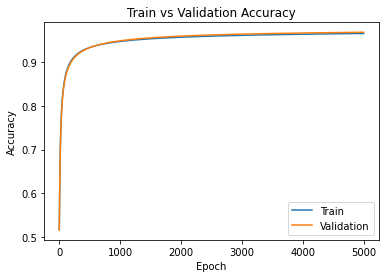

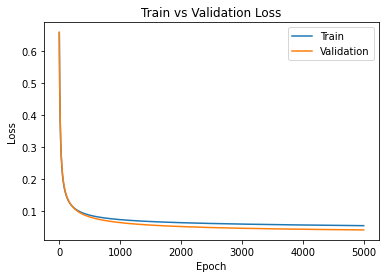

Results for alpha = 0.001 

Test Loss: 0.07548118132140244 Test Accuracy: 0.9497272391818716  



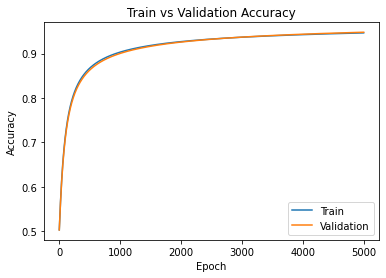

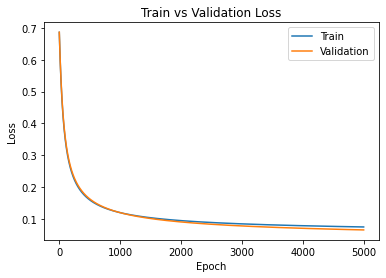

Results for alpha = 0.0001 

Test Loss: 0.15197003977012832 Test Accuracy: 0.8742850624175114  



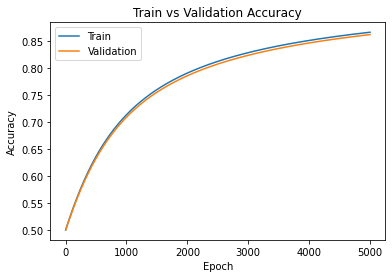

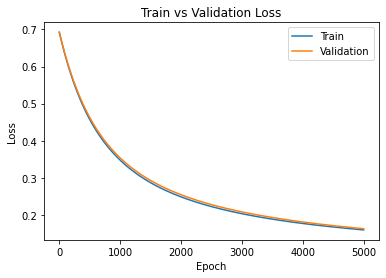

In [5]:
#Graphs for learning rate experiments
print("Regarding the effects of the learning rate \n")
print("Impact of learning rate, α = {0.005, 0.001, 0.0001} on the performance of your classifier on loss and acc \n")
print("Results for alpha = 0.005 \n")
(w_opt,b_opt) = grad_descent(w,b,x,y,alpha,epochs,lambda_reg,error_tol, val_tuple, test_tuple)
print("Results for alpha = 0.001 \n")
(w_opt1,b_opt1) = grad_descent(w1,b1,x,y,alpha1,epochs,lambda_reg,error_tol, val_tuple, test_tuple)
print("Results for alpha = 0.0001 \n")
(w_opt2,b_opt2) = grad_descent(w2,b2,x,y,alpha2,epochs,lambda_reg,error_tol, val_tuple, test_tuple)

In [6]:
Y_tr = trainTarget
Y_val = validTarget
Y_test = testTarget
#Values for learning rate experiments
Y_OUT_tr = decision(w_opt,b_opt,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt,b_opt,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt,b_opt,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.005 \n")
print("Training Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 outoput:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")

Y_OUT_tr = decision(w_opt1,b_opt1,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt1,b_opt1,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt1,b_opt1,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.001 \n")
print("Training Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")

Y_OUT_tr = decision(w_opt2,b_opt2,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt2,b_opt2,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt2,b_opt2,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.0001 \n")
print("Training Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 output:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")


Results for alpha = 0.005 

Training Accuracy after conversion to 0 and 1 output: 98.31428571428572 %
Validation Accuracy after conversion to 0 and 1 outoput: 98.0 %
Testing Accuracy after conversion to 0 and 1 output: 97.93103448275862 % 

Results for alpha = 0.001 

Training Accuracy after conversion to 0 and 1 output: 97.85714285714285 %
Validation Accuracy after conversion to 0 and 1 output: 98.0 %
Testing Accuracy after conversion to 0 and 1 output: 96.55172413793103 % 

Results for alpha = 0.0001 

Training Accuracy after conversion to 0 and 1 output: 97.39999999999999 %
Validation Accuracy after conversion to 0 and 1 output: 97.0 %
Testing Accuracy after conversion to 0 and 1 output: 97.24137931034483 % 



## 1.4 Generalization

* Impact of regularization by modifying the regularization parameter, λ =
{0.001, 0.1, 0.5} for α = 0.005:

  Higher regularization parameters allow the accuracies and losses of different sets to behave more alike, therefore allowing for generalization and dampening of the effects of higher w values (a possible downside is that accuracies achieved tend to be lower the higher lambda is). This parameter helps in avoiding problems with fitting as shown in the graphs below.

* Explain how you choose the best parameter, and what
accuracy you report for the selected model:

  I chose alpha = 0.005, lambda = 0.1 to be my best parameter in this part of the assignment due to its adequate accuracy and generalization across all sets:
  
  Training Accuracy after conversion to 0 and 1 outout: 98.0 %

  Validation Accuracy after conversion to 0 and 1 outout: 98.0 %

  Testing Accuracy after conversion to 0 and 1 outout: 97.93103448275862 %


* Accuracies and Losses alongside their respective graphs for the different λ s are listed below:

Regarding the effects of the regularization parameter rate 

Impact of regularization by modifying the regularization parameter, λ = {0.001, 0.1, 0.5} for α = 0.005 on the performance of  classifier on loss and acc 

Results for alpha = 0.005 lambda = 0.001 

Test Loss: 0.06879136852310944 Test Accuracy: 0.9665223339523129  



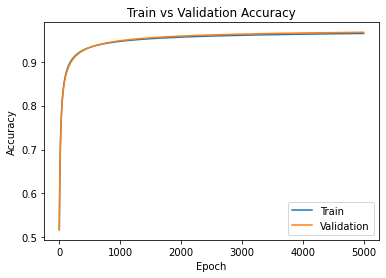

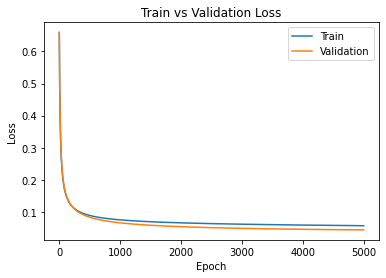

Results for alpha = 0.005 lambda = 0.1 

Test Loss: 0.11616069062175155 Test Accuracy: 0.9431801012248988  



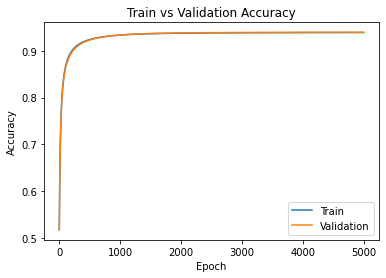

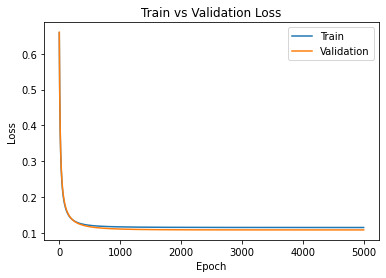

Results for alpha = 0.005 lambda = 0.5 

Test Loss: 0.19311040552785202 Test Accuracy: 0.8999951434923025  



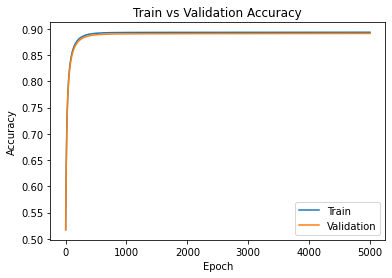

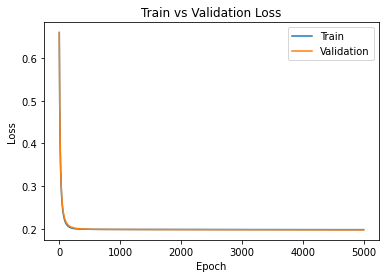

In [7]:
#Graphs for regularization experiments
print("Regarding the effects of the regularization parameter rate \n")
print("Impact of regularization by modifying the regularization parameter, λ = {0.001, 0.1, 0.5} for α = 0.005 on the performance of  classifier on loss and acc \n")
print("Results for alpha = 0.005 lambda = 0.001 \n")
(w_opt3,b_opt3) = grad_descent(w3,b3,x,y,alpha,epochs,lambda_reg1,error_tol, val_tuple, test_tuple)
print("Results for alpha = 0.005 lambda = 0.1 \n")
(w_opt4,b_opt4) = grad_descent(w4,b4,x,y,alpha,epochs,lambda_reg2,error_tol, val_tuple, test_tuple)
print("Results for alpha = 0.005 lambda = 0.5 \n")
(w_opt5,b_opt5) = grad_descent(w5,b5,x,y,alpha,epochs,lambda_reg3,error_tol, val_tuple, test_tuple)

In [8]:
#Values for regularization experiments
Y_OUT_tr = decision(w_opt3,b_opt3,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt3,b_opt3,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt3,b_opt3,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.005 lambda = 0.001 \n")
print("Training Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")

Y_OUT_tr = decision(w_opt4,b_opt4,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt4,b_opt4,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt4,b_opt4,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.005 lambda = 0.1 \n")
print("Training Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")

Y_OUT_tr = decision(w_opt5,b_opt5,trainDataf)
Y_OUT_tr_actual = get_actual_out_labels(Y_OUT_tr)
Y_OUT_val = decision(w_opt5,b_opt5,val_tuple[0])
Y_OUT_val_actual = get_actual_out_labels(Y_OUT_val)
Y_OUT_test = decision(w_opt5,b_opt5,test_tuple[0])
Y_OUT_test_actual = get_actual_out_labels(Y_OUT_test)
print("Results for alpha = 0.005 lambda = 0.5 \n")
print("Training Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_tr_actual, Y_tr), "%")
print("Validation Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_val_actual, Y_val), "%")
print("Testing Accuracy after conversion to 0 and 1 outout:",100*get_acc(Y_OUT_test_actual, Y_test), "% \n")

Results for alpha = 0.005 lambda = 0.001 

Training Accuracy after conversion to 0 and 1 outout: 98.31428571428572 %
Validation Accuracy after conversion to 0 and 1 outout: 98.0 %
Testing Accuracy after conversion to 0 and 1 outout: 97.93103448275862 % 

Results for alpha = 0.005 lambda = 0.1 

Training Accuracy after conversion to 0 and 1 outout: 98.0 %
Validation Accuracy after conversion to 0 and 1 outout: 98.0 %
Testing Accuracy after conversion to 0 and 1 outout: 97.93103448275862 % 

Results for alpha = 0.005 lambda = 0.5 

Training Accuracy after conversion to 0 and 1 outout: 97.57142857142857 %
Validation Accuracy after conversion to 0 and 1 outout: 97.0 %
Testing Accuracy after conversion to 0 and 1 outout: 96.55172413793103 % 

